In [1]:
import src
from src.simul_sweep import SimulSweep
from src.daq_driver import Daq
from src.base_sweep import BaseSweep
import nidaqmx
import time, os
import numpy as np
import qcodes as qc
from src.util import connect_to_station, connect_station_instruments
from qcodes import initialise_or_create_database_at, load_by_run_spec
from qcodes import Station
from qcodes.instrument_drivers.Lakeshore.Model_372 import Model_372
from qcodes.instrument_drivers.american_magnetics.AMI430 import AMI430
from qcodes.instrument_drivers.stanford_research.SR860 import SR860
from qcodes_contrib_drivers.drivers.Oxford.IPS120 import OxfordInstruments_IPS120

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nanouser\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nanouser\.qcodes\logs\210415-12416-qcodes.log


## Initialize the magnet driver

In [2]:
magnet = OxfordInstruments_IPS120('magnet', 'GPIB0::25::INSTR', use_gpib=True)

## Let's make sure we're connected and everything is as we expect

In [3]:
magnet.identify()

'IPS120-10  Version 3.07  (c) OXFORD 1996'

In [4]:
magnet.examine()

System Status: 
Normal
Activity: 
Hold
Local/Remote status: 
Local and locked
Switch heater: 
Off magnet at zero (switch closed)
Mode: 
Tesla, Magnet sweep: fast
Polarity: 
Desired: Positive, Magnet: Positive, Commanded: Positive, Both contactors open


## Set the control status 
#### 0 : Local and locked
#### 1 : Remote and locked
#### 2 : Local and unlocked
#### 3 : Remote and unlocked

In [5]:
magnet.remote_status(3)

### We can check and set the field setpoints and the sweeprate of the field

In [9]:
magnet.field_setpoint()

1.0

In [7]:
magnet.field_setpoint(1)

In [8]:
magnet.sweeprate_field()

0.3

In [7]:
magnet.sweeprate_field(0.3)

## Check (and set) the activity status
#### 0 : Hold
#### 1 : Goto zero
#### 2 : Goto setpoint

In [10]:
magnet.activity()

'Hold'

## Turn the switch heater on to enable the field to be ramped

In [11]:
magnet.heater_on()

Setting switch heater... (wait 40s)


## Now, we can run to the field, either by calling 'run_to_field', or setting the activity to 'goto setpoint' 

In [18]:
magnet.run_to_field(6)

## If we want to stay at field to do measurements, hold the field in place by setting persistent mode

In [19]:
magnet.set_persistent()

Setting switch heater... (wait 40s)
Waiting for the switch heater to become superconducting


#### You can check that we're in persistent mode by checking the persistent field (field in the magnet) and the field (which is the current going through the leads- should be 0)

In [12]:
magnet.persistent_field()

0.0

In [25]:
magnet.field()

0.0

## Once done, leave persistent mode so we can ramp the field back to zero

In [24]:
magnet.leave_persistent_mode()

Setting switch heater... (wait 40s)


## Once we are done, we can go back to 0 either by 'run_to_field' or setting activity to 'goto zero'

In [21]:
magnet.run_to_field(0)

## Finally, switch the heater off and set us to 'hold'

In [28]:
magnet.heater_off()
magnet.activity(0)

Setting switch heater... (wait 40s)


## Double check to make sure the field and current are 0, and it is set to hold, and you can turn the IPS power off

In [19]:
def mag_sweep(magnet_value):
    if abs(magnet_value) < 5:
        magnet.leave_persistent_mode()
        magnet.run_to_field(magnet_value)
        magnet.set_persistent()
    else:
        magnet.run_to_field(magnet_value)

done_with_sweeps=False
def iterate():
    done_with_sweeps=True

for B in mag_value:
    done_with_sweeps = False
    
    tg_zero_sweep = Sweep1D(keithley_tg.source.voltage, 0, -8, .15, inter_delay=.5, x_axis_time=0)
    tg_forward_sweep = Sweep1D(keithley_tg.source.voltage, -8, 8, .05, inter_delay=.5, x_axis_time=0)
    tg_backward_sweep = Sweep1D(keithley_tg.source.voltage, 8, 0, .15, inter_delay=.5, x_axis_time=0)

    tg_zero_sweep.follow_param()

    mag_sweep(B)
    sleep(0.3*(dB)*60)
    
    tg_zero_sweep.set_complete_func(tg_forward_sweep.start)
    tg_forward_sweep.set_complete_func(tg_backward_sweep.start)
    tg_backward_sweep.set_complete_func(iterate #lambda: step_magnet(B))
    
    #tg_zero_sweep.start()
    
    while not done_with_sweeps:
        sleep(1)
    while tg_zero_sweep.is_running:
        sleep(0.1)
    while tg_forward_sweep.isrunning:
        sleep(0.1)


SyntaxError: invalid syntax (<ipython-input-19-ac960e9a51c4>, line 6)

In [20]:
from src.sweep_ips import SweepIPS

In [21]:
sr860 = SR860('sr860', 'USB0::0xB506::0x2000::003594::INSTR')

Connected to: Stanford_Research_Systems SR860 (serial:003594, firmware:V1.51) in 0.07s


In [22]:
sweep = SweepIPS(magnet, 0, inter_delay=0.25, save_data=True, persistent_magnet=False, plot_data = True)
sweep.follow_param(sr860.X, sr860.P)

In [23]:
try:
    # Make sure database_name and the path are set to the correct values!
    db = 'Databases\\SW2.db'
    exp_name = "B sweep T=1p5K Vbg=+100V_Vtg=+1V"
    sample_name = "V2-6=500uVac_gain=1e8_ground others"
    initialise_or_create_database_at(db)
    qc.new_experiment(name=exp_name, sample_name=sample_name)
except:
    print("Error opening database")

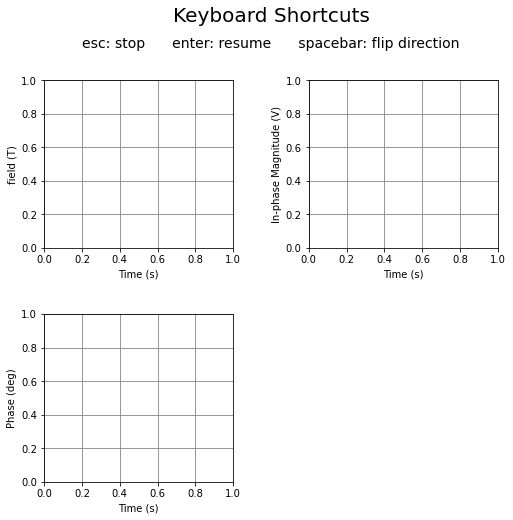

Starting experimental run with id: 177. 
Checking the status of the magnet and switch heater.
Heater is already on, so the magnet was not in persistent mode
Done with the sweep, t=1201.8280000000086 s


In [25]:
sweep.start()

In [27]:
sweep.kill()

In [26]:
sweep.is_running

Done with the sweep!


False